<a href="https://colab.research.google.com/github/sanskar770/CatvsDog/blob/main/CatvsDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets


In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/tongpython/cat-and-dog")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sanskarshma
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog


100%|██████████| 218M/218M [00:00<00:00, 922MB/s] 


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [4]:
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/cat-and-dog/training_set/training_set',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)

Found 8005 files belonging to 2 classes.


In [5]:
test_ds=keras.utils.image_dataset_from_directory(
    directory='/content/cat-and-dog/test_set/test_set',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)

Found 2023 files belonging to 2 classes.


In [6]:
def process(image,label):
  image=tf.cast(image/255. ,tf.float32)
  return image,label
train_ds=train_ds.map(process)
test_ds=test_ds.map(process)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1/255,
        validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/cat-and-dog/training_set/training_set',
    target_size=(300,300),
    batch_size=128,
    class_mode='binary',
    save_to_dir=None,       # remove saving to avoid slowdown
    save_prefix='modified',
    subset="training"
)
val_generator = datagen.flow_from_directory(
    '/content/cat-and-dog/training_set/training_set',
    target_size=(300,300),
    batch_size=128,
    class_mode='binary',
    subset="validation"
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [14]:
def build_model(hp):
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(
        filters=hp.Choice("conv1_filters", [32, 64, 128]),
        kernel_size=(3,3),
        activation='relu',
        input_shape=(256,256,3)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    # Conv Block 2
    model.add(Conv2D(
        filters=hp.Choice("conv2_filters", [64, 128, 256]),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    # Conv Block 3
    model.add(Conv2D(
        filters=hp.Choice("conv3_filters", [128, 256, 512]),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())

    # Dense Layer
    model.add(Dense(
        units=hp.Choice("dense_units", [64, 128, 256, 512]),
        activation="relu"
    ))

    # Dropout
    model.add(Dropout(
        hp.Choice("dropout_rate", [0.1, 0.2, 0.3, 0.4])
    ))

    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4])
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [15]:
!pip install keras-tuner
import keras_tuner as kt
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_results",
    project_name="cats_dogs_cnn"
)
tuner.search(train_ds, epochs=5, validation_data=test_ds)

best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Trial 10 Complete [00h 09m 25s]
val_accuracy: 0.5190311670303345

Best val_accuracy So Far: 0.7899159789085388
Total elapsed time: 00h 56m 00s
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 65s 236ms/step - accuracy: 0.6000 - loss: 0.8094 - val_accuracy: 0.5002 - val_loss: 10.9834
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.7049 - loss: 0.5448 - val_accuracy: 0.6426 - val_loss: 0.6732
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.7753 - loss: 0.4673 - val_accuracy: 0.7558 - val_loss: 0.5249
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.8312 - loss: 0.3717 - val_accuracy: 0.7771 - val_loss: 0.4870
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 226ms/step - accuracy: 0.8775 - loss: 0.2893 - val_accuracy: 0.7785 - val_loss: 0.5161
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.9021 - loss: 0.2348 - val_accuracy: 0.7652 - val_loss: 0.5236
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 226ms/step - accuracy: 0.9

In [16]:
history.summary()

AttributeError: 'History' object has no attribute 'summary'

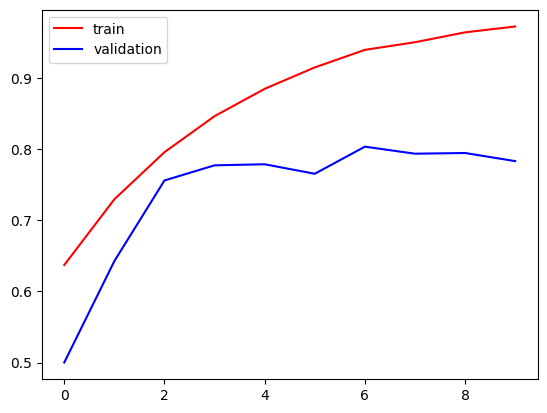

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

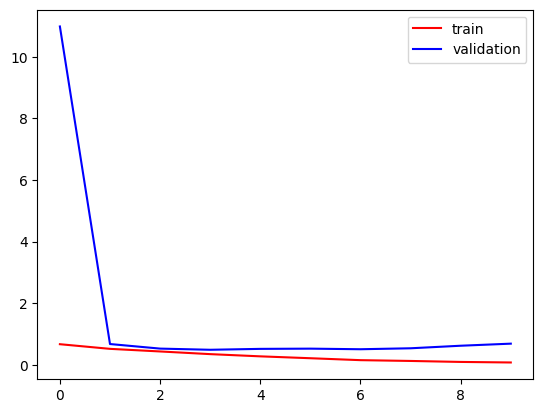

In [18]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [26]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  path = '/content/' + fn
  img=load_img(path,target_size=(256,256))
  x=img_to_array(img)
  x /= 255
  print(f"shape of image:{x.shape}")
  x = np.expand_dims(x, axis=0)
  #print(x)
  images = np.vstack([x])
  #print(images)
  classes = model.predict(images, batch_size=10)
  print(classes)
  print(classes[0])
  if classes[0] > 0.5:
        print("Prediction: Dog")
  else:
        print("Prediction: Cat")


Saving cat.jpg to cat.jpg
cat.jpg
shape of image:(256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[0.00023564]]
[0.00023564]
Prediction: Cat
